# Dreaddit: Stress Detection in Social Media Text
## Binary Classification of Stressed vs Non-Stressed Reddit Posts

**Author:** [Harry Yeo Rui Bin A0252832H]  
**GitHub:** [https://github.com/harryruibinyeo/DSA4262]  
**Date:** 25 February 2026

---

### Overview

This notebook builds and evaluates predictive models for detecting psychological stress in social media posts using the **Dreaddit dataset** (Turcan & McKeown, 2019). The dataset contains 3,553 five-sentence segments from Reddit posts across five domains — abuse, anxiety, financial need, PTSD, and interpersonal relationships — each labeled as stressed or not-stressed by Amazon Mechanical Turk annotators.

We take a two-model approach:

1. **Logistic Regression** with pre-computed psycholinguistic features (LIWC, DAL, sentiment, syntax, social metadata) — chosen for its strong interpretability and the paper's finding that stress detection is a highly *lexical* problem where feature quality matters more than quantity.

2. **Fine-tuned DistilBERT** on raw text — chosen to capture contextual semantic patterns (sarcasm, implicit stress, narrative framing) that bag-of-features approaches miss. 

Beyond classification performance, we conduct three deep-dive analyses: subreddit-level predictability, confident misclassification patterns, and linguistic feature analysis. We conclude with a discussion of real-world deployment considerations.

---

## 1. Setup and Data Loading

In [2]:
# ============================================================
# 1.1 Install required packages
# ============================================================
# !pip install pandas numpy matplotlib seaborn scikit-learn transformers torch datasets

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, f1_score,
    precision_score, recall_score, accuracy_score, roc_auc_score
)
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Set global styling
sns.set_theme(style='whitegrid', palette='muted', font_scale=1.1)
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100

SEED = 42
np.random.seed(SEED)

print('Setup complete.')

Setup complete.


In [4]:
# ============================================================
# 1.2 Load data
# ============================================================
train_df = pd.read_csv('data/dreaddit-train.csv')
test_df = pd.read_csv('data/dreaddit-test.csv')

print(f'Training set: {train_df.shape[0]} samples, {train_df.shape[1]} columns')
print(f'Test set:     {test_df.shape[0]} samples, {test_df.shape[1]} columns')
print(f'\nTotal features (excluding metadata): {train_df.shape[1] - 7}')

Training set: 2838 samples, 116 columns
Test set:     715 samples, 116 columns

Total features (excluding metadata): 109


In [5]:
# ============================================================
# 1.3 Map subreddits to domains 
# ============================================================
SUBREDDIT_TO_DOMAIN = {
    'domesticviolence': 'abuse',
    'survivorsofabuse': 'abuse',
    'anxiety': 'anxiety',
    'stress': 'anxiety',
    'almosthomeless': 'financial',
    'assistance': 'financial',
    'food_pantry': 'financial',
    'homeless': 'financial',
    'ptsd': 'PTSD',
    'relationships': 'social'
}

train_df['domain'] = train_df['subreddit'].map(SUBREDDIT_TO_DOMAIN)
test_df['domain'] = test_df['subreddit'].map(SUBREDDIT_TO_DOMAIN)

print('Domain mapping applied.')
print('\nDomain distribution (train):')
print(train_df['domain'].value_counts())

Domain mapping applied.

Domain distribution (train):
domain
PTSD         584
financial    574
anxiety      567
abuse        561
social       552
Name: count, dtype: int64


In [6]:
# ============================================================
# 1.4 Data Inspection
# ============================================================
print('Columns in the dataset:')
print('=' * 60)
print(f'Metadata:      subreddit, post_id, sentence_range, text, id')
print(f'Target:        label (0=not stressed, 1=stressed)')
print(f'Annotation:    confidence (proportion of annotators who agreed)')
print(f'Social:        social_timestamp, social_karma, social_upvote_ratio, social_num_comments')
print(f'Syntax:        syntax_ari (Automated Readability Index), syntax_fk_grade (Flesch-Kincaid)')
print(f'LIWC (93):     Linguistic Inquiry and Word Count — psycholinguistic word categories')
print(f'DAL (9):       Dictionary of Affect — pleasantness, activation, imagery (avg/min/max)')
print(f'Sentiment (1): Pattern library sentiment score')
print('=' * 60)
print(f'\nMissing values: {train_df.isnull().sum().sum()} (train), {test_df.isnull().sum().sum()} (test)')

train_df.head(3)

Columns in the dataset:
Metadata:      subreddit, post_id, sentence_range, text, id
Target:        label (0=not stressed, 1=stressed)
Annotation:    confidence (proportion of annotators who agreed)
Social:        social_timestamp, social_karma, social_upvote_ratio, social_num_comments
Syntax:        syntax_ari (Automated Readability Index), syntax_fk_grade (Flesch-Kincaid)
LIWC (93):     Linguistic Inquiry and Word Count — psycholinguistic word categories
DAL (9):       Dictionary of Affect — pleasantness, activation, imagery (avg/min/max)
Sentiment (1): Pattern library sentiment score

Missing values: 0 (train), 0 (test)


,subreddit,post_id,sentence_range,text,id,label,confidence,social_timestamp,social_karma,syntax_ari,...,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment,domain
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",33181,1,0.8,1521614353,5,1.806818,...,1.1250,1.0,1.77000,1.52211,1.89556,0.86,1,3.253573,-0.002742,PTSD
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",2606,0,1.0,1527009817,4,9.429737,...,1.0000,1.0,1.69586,1.62045,1.88919,0.65,2,8.828316,0.292857,financial
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,38816,1,0.8,1535935605,2,7.769821,...,1.1429,1.0,1.83088,1.58108,1.85828,0.67,0,7.841667,0.011894,PTSD


---
## 2. Exploratory Data Analysis

Before modelling, we examine the data to understand label distributions, domain characteristics, and the linguistic features that differentiate stressed from non-stressed posts. This exploration directly informs our feature selection and helps us anticipate where models may struggle.


### 2.1 Label Distribution

We check whether the dataset is balanced. An imbalanced dataset would require class-weighted loss or oversampling; a balanced one lets us train without special adjustments.

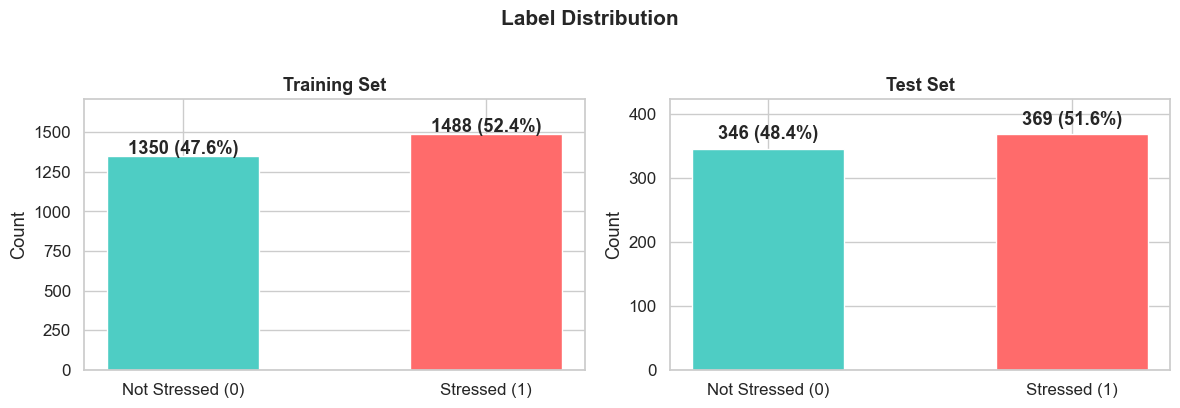

Dataset is nearly balanced — train: 52.4% stressed, test: 51.6% stressed.


In [7]:
# ============================================================
# 2.1 Label distribution
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, df, title in zip(axes, [train_df, test_df], ['Training Set', 'Test Set']):
    counts = df['label'].value_counts().sort_index()
    colors = ['#4ECDC4', '#FF6B6B']
    bars = ax.bar(['Not Stressed (0)', 'Stressed (1)'], counts.values, color=colors, edgecolor='white', width=0.5)
    for bar, count in zip(bars, counts.values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 15, 
                f'{count} ({count/len(df)*100:.1f}%)', ha='center', fontweight='bold')
    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.set_ylabel('Count')
    ax.set_ylim(0, max(counts.values) * 1.15)

plt.suptitle('Label Distribution', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print(f'Dataset is nearly balanced — train: {train_df["label"].mean()*100:.1f}% stressed, '
      f'test: {test_df["label"].mean()*100:.1f}% stressed.')

### 2.2 Stress Rate by Subreddit and Domain

We visualise stress prevalence across subreddits to see if some communities express stress more frequently. This matters because a model that simply learns "r/anxiety = stressed" would not generalise — it must learn *linguistic* signals.

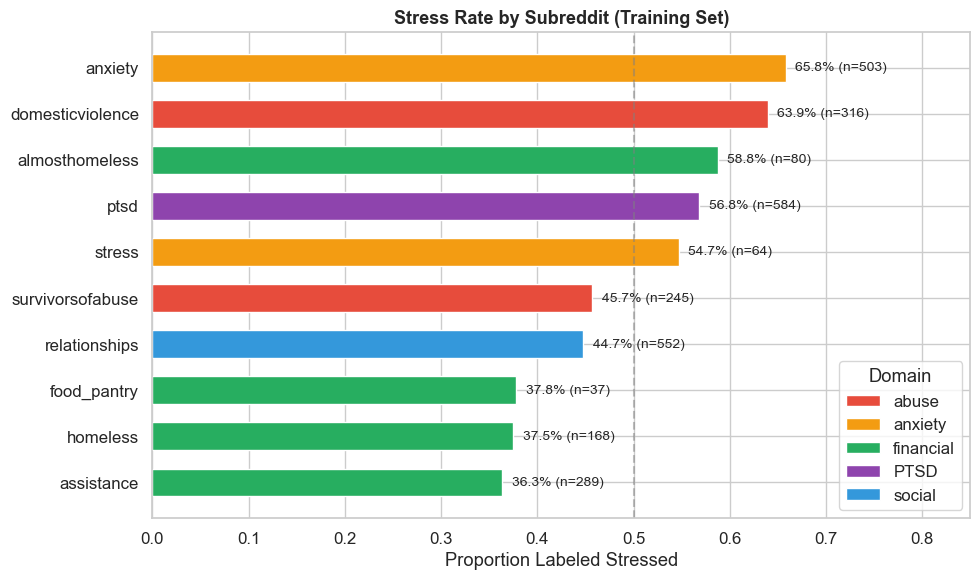

In [8]:
# ============================================================
# 2.2 Stress rate by subreddit/domain
# ============================================================
stress_by_sub = train_df.groupby('subreddit').agg(
    stress_rate=('label', 'mean'),
    count=('label', 'size'),
    domain=('domain', 'first')
).sort_values('stress_rate', ascending=True)

domain_colors = {
    'abuse': '#E74C3C', 'anxiety': '#F39C12', 'financial': '#27AE60',
    'PTSD': '#8E44AD', 'social': '#3498DB'
}
bar_colors = [domain_colors[d] for d in stress_by_sub['domain']]

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(stress_by_sub.index, stress_by_sub['stress_rate'], color=bar_colors, edgecolor='white', height=0.6)

for bar, rate, count in zip(bars, stress_by_sub['stress_rate'], stress_by_sub['count']):
    ax.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
            f'{rate:.1%} (n={count})', va='center', fontsize=10)

ax.axvline(x=0.5, color='gray', linestyle='--', alpha=0.5, label='50% baseline')
ax.set_xlabel('Proportion Labeled Stressed')
ax.set_title('Stress Rate by Subreddit (Training Set)', fontsize=13, fontweight='bold')
ax.set_xlim(0, 0.85)

# Legend for domains
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=c, label=d) for d, c in domain_colors.items()]
ax.legend(handles=legend_elements, loc='lower right', title='Domain')

plt.tight_layout()
plt.show()

Stress prevalence varies substantially: 
- r/anxiety (65.8%) and r/domesticviolence (63.9%) have the highest rates
- r/assistance (36.3%) and r/food_pantry (37.8%) have the lowest rates 

Mental health communities or subreddits are spaces for emotional processing, so more posts express active distress. 

Financial subreddits often contain practical requests ("I need help with rent") expressed in transactional rather than emotional language. This variation means a model must learn domain-specific patterns rather than relying on subreddit alone.


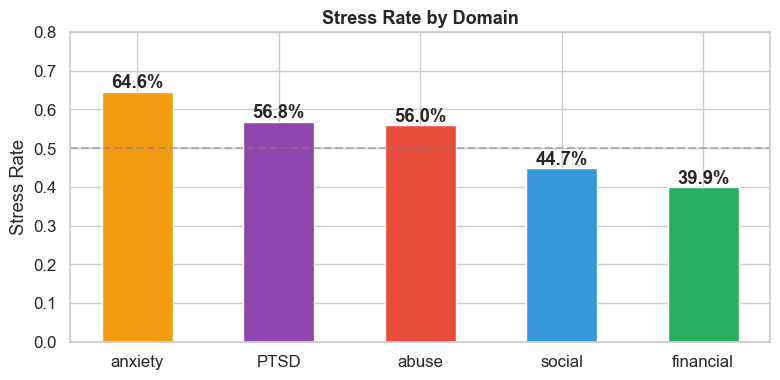

In [9]:
# ============================================================
# 2.2 Stress rate by domain
# ============================================================
stress_by_domain = train_df.groupby('domain').agg(
    stress_rate=('label', 'mean'),
    count=('label', 'size')
).sort_values('stress_rate', ascending=False)

fig, ax = plt.subplots(figsize=(8, 4))
colors = [domain_colors[d] for d in stress_by_domain.index]
bars = ax.bar(stress_by_domain.index, stress_by_domain['stress_rate'], color=colors, edgecolor='white', width=0.5)
for bar, rate in zip(bars, stress_by_domain['stress_rate']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{rate:.1%}', ha='center', fontweight='bold')
ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
ax.set_ylabel('Stress Rate')
ax.set_title('Stress Rate by Domain', fontsize=13, fontweight='bold')
ax.set_ylim(0, 0.8)
plt.tight_layout()
plt.show()

### 2.3 Annotator Confidence Distribution

The `confidence` column reflects annotator agreement (Fleiss' κ = 0.47 across the full dataset, which is "moderate agreement"). About 40% of training samples have perfect agreement, but a substantial portion has confidence around 0.57–0.60 (barely majority). 

This ambiguity is inherent to stress — it is a subjective experience and annotators naturally disagree on borderline cases. The paper found that filtering to high-agreement data (≥ 80%) improved model performance, which we will leverage.

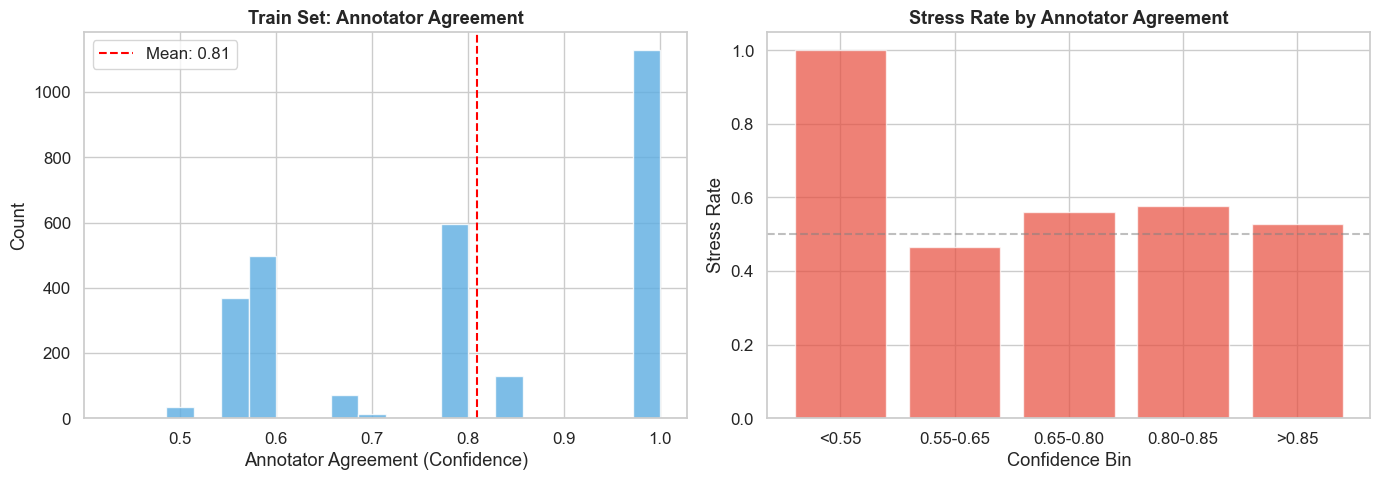

Annotator agreement: mean=0.809, perfect agreement on 39.7% of data


In [10]:
# ============================================================
# 2.3 Annotator confidence distribution
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Train confidence
axes[0].hist(train_df['confidence'], bins=20, color='#5DADE2', edgecolor='white', alpha=0.8)
axes[0].set_xlabel('Annotator Agreement (Confidence)')
axes[0].set_ylabel('Count')
axes[0].set_title('Train Set: Annotator Agreement', fontweight='bold')
axes[0].axvline(x=train_df['confidence'].mean(), color='red', linestyle='--', 
                label=f'Mean: {train_df["confidence"].mean():.2f}')
axes[0].legend()

# Confidence vs stress rate
conf_bins = pd.cut(train_df['confidence'], bins=[0, 0.55, 0.65, 0.8, 0.85, 1.01], 
                   labels=['<0.55', '0.55-0.65', '0.65-0.80', '0.80-0.85', '>0.85'])
stress_by_conf = train_df.groupby(conf_bins, observed=False)['label'].agg(['mean', 'count'])
axes[1].bar(range(len(stress_by_conf)), stress_by_conf['mean'], color='#E74C3C', alpha=0.7, edgecolor='white')
axes[1].set_xticks(range(len(stress_by_conf)))
axes[1].set_xticklabels(stress_by_conf.index, rotation=0)
axes[1].set_xlabel('Confidence Bin')
axes[1].set_ylabel('Stress Rate')
axes[1].set_title('Stress Rate by Annotator Agreement', fontweight='bold')
axes[1].axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

print(f'Annotator agreement: mean={train_df["confidence"].mean():.3f}, '
      f'perfect agreement on {(train_df["confidence"]==1.0).mean()*100:.1f}% of data')

About 39.7% of training samples have perfect agreement, 65.2% have ≥80%. The remaining ~35% have weak consensus, reflecting the inherent subjectivity of stress.

### 2.4 Key LIWC Features: Stressed vs Non-Stressed

We compare distributions of 8 psychologically meaningful features between labels. These were chosen because the paper identified them as most informative and they have clear interpretations in the mental health literature.

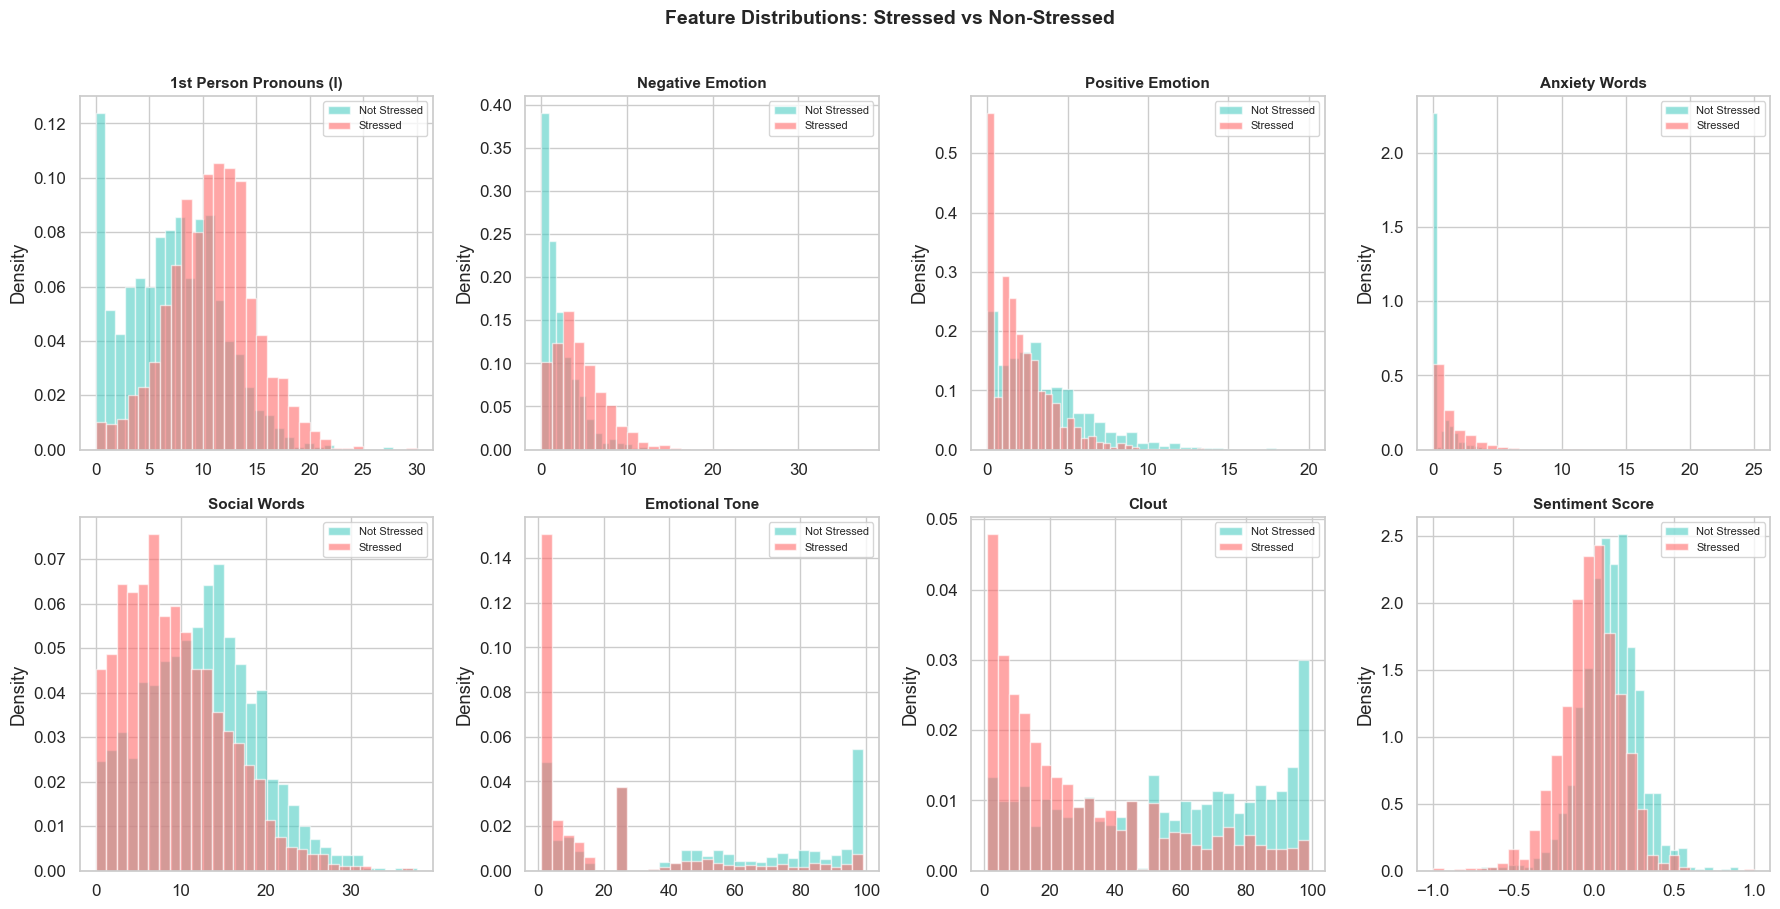

In [11]:
# ============================================================
# 2.4 Key LIWC features: stressed vs non-stressed
# ============================================================
key_features = [
    ('lex_liwc_i', '1st Person Pronouns (I)'),
    ('lex_liwc_negemo', 'Negative Emotion'),
    ('lex_liwc_posemo', 'Positive Emotion'),
    ('lex_liwc_anx', 'Anxiety Words'),
    ('lex_liwc_social', 'Social Words'),
    ('lex_liwc_Tone', 'Emotional Tone'),
    ('lex_liwc_Clout', 'Clout'),
    ('sentiment', 'Sentiment Score'),
]

fig, axes = plt.subplots(2, 4, figsize=(18, 9))
axes = axes.flatten()

for idx, (feat, title) in enumerate(key_features):
    ax = axes[idx]
    stressed = train_df[train_df['label']==1][feat]
    not_stressed = train_df[train_df['label']==0][feat]
    
    ax.hist(not_stressed, bins=30, alpha=0.6, color='#4ECDC4', label='Not Stressed', density=True)
    ax.hist(stressed, bins=30, alpha=0.6, color='#FF6B6B', label='Stressed', density=True)
    ax.set_title(title, fontweight='bold', fontsize=11)
    ax.legend(fontsize=8)
    ax.set_ylabel('Density')

plt.suptitle('Feature Distributions: Stressed vs Non-Stressed', fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

Several clear patterns emerge that align with the paper's findings and the broader mental health literature:

- **First-person pronouns** are higher in stressed posts, consistent with increased self-focus during psychological distress.
- **Negative emotion** and **anxiety words** are elevated in stressed posts, while **positive emotion** is lower — the most intuitive signal.
- **Social words** are higher in non-stressed posts, possibly reflecting better social support or third-person narrative framing.
- **Tone** (LIWC's composite emotional tone metric) is strongly separating — stressed posts skew toward low tone (negative), while non-stressed posts have higher tone.
- **Clout** (LIWC's measure of social status/confidence in writing) is lower in stressed posts, suggesting more uncertain, vulnerable language.

The distributions reveal clear separations: 
- First-person pronouns average 10.84% in stressed vs 7.11% in non-stressed. 
- Negative emotion words are roughly double. 
- LIWC Tone shows the largest gap: 18.8 vs 49.6 — stressed posts are dramatically more negative. 
- Clout (social confidence) is 28.8 vs 54.3, reflecting more vulnerable, uncertain language in stressed writing.

### 2.5 Text Length and Correlation Heatmap

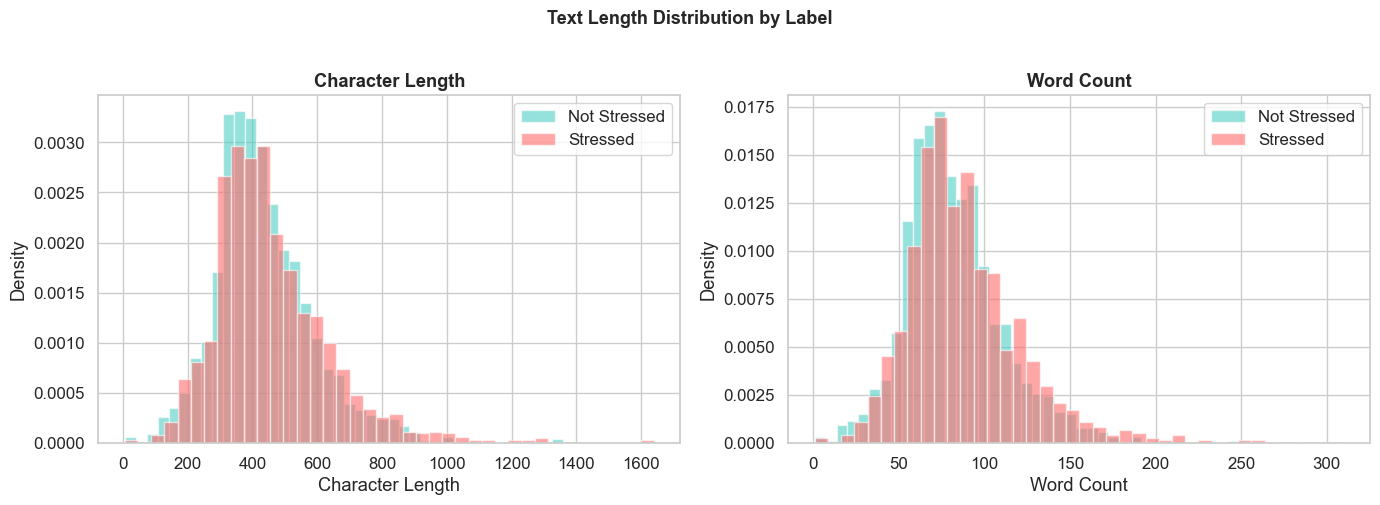

Stressed posts — avg word count: 88.8
Non-stressed posts — avg word count: 82.2


In [12]:
# ============================================================
# 2.5 Text length analysis
# ============================================================
train_df['text_length'] = train_df['text'].str.len()
train_df['word_count'] = train_df['text'].str.split().str.len()
test_df['text_length'] = test_df['text'].str.len()
test_df['word_count'] = test_df['text'].str.split().str.len()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, col, title in zip(axes, ['text_length', 'word_count'], ['Character Length', 'Word Count']):
    ax.hist(train_df[train_df['label']==0][col], bins=40, alpha=0.6, color='#4ECDC4', label='Not Stressed', density=True)
    ax.hist(train_df[train_df['label']==1][col], bins=40, alpha=0.6, color='#FF6B6B', label='Stressed', density=True)
    ax.set_title(title, fontweight='bold')
    ax.set_xlabel(title)
    ax.set_ylabel('Density')
    ax.legend()

plt.suptitle('Text Length Distribution by Label', fontsize=13, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

print(f'Stressed posts — avg word count: {train_df[train_df["label"]==1]["word_count"].mean():.1f}')
print(f'Non-stressed posts — avg word count: {train_df[train_df["label"]==0]["word_count"].mean():.1f}')

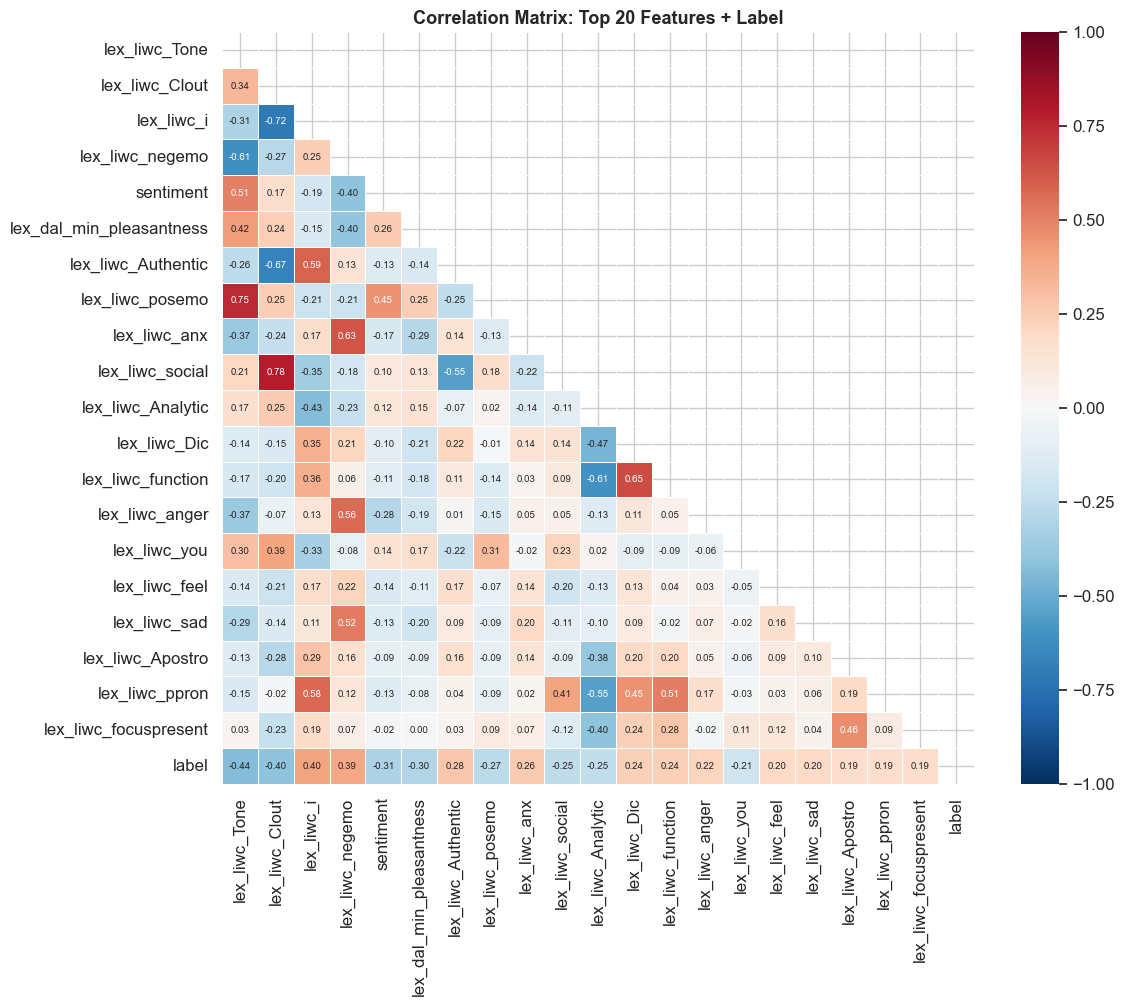

In [13]:
# ============================================================
# 2.5 Correlation heatmap of top features with label
# ============================================================
feature_cols = [c for c in train_df.columns if c not in 
                ['subreddit','post_id','sentence_range','text','id','label','confidence','domain','text_length','word_count']]

# Get top 20 by absolute correlation with label
corrs = train_df[feature_cols + ['label']].corr()['label'].drop('label')
top20 = corrs.abs().sort_values(ascending=False).head(20).index.tolist()

fig, ax = plt.subplots(figsize=(12, 10))
corr_matrix = train_df[top20 + ['label']].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            square=True, linewidths=0.5, ax=ax, vmin=-1, vmax=1,
            annot_kws={'size': 7})
ax.set_title('Correlation Matrix: Top 20 Features + Label', fontweight='bold', fontsize=13)
plt.tight_layout()
plt.show()

The correlation analysis reveals that the three features with the highest absolute correlation to the stress label are:
- LIWC's **Tone** (r = −0.44)
- **Clout** (r = −0.40)
- **first-person pronoun usage** (r = +0.40). 

These are exactly the features identified in the original paper as the high-correlation set (|r| ≥ 0.4). The heatmap also shows substantial inter-correlation among LIWC features (e.g., Tone correlates with posemo and negemo), which motivates regularisation in our logistic regression model to handle multicollinearity.

---
## 3. Feature Engineering

The dataset comes pre-loaded with 109 features. Our feature engineering strategy is informed by the paper's finding that **feature quality trumps quantity** — high-correlation features (|r| ≥ 0.4) outperformed using all features. We define three feature sets to experiment with.



In [14]:
# ============================================================
# 3.1 Define feature groups
# ============================================================
META_COLS = ['subreddit', 'post_id', 'sentence_range', 'text', 'id', 'label', 'confidence', 'domain', 'text_length', 'word_count']

# All pre-computed features
ALL_FEATURES = [c for c in train_df.columns if c not in META_COLS]

# LIWC features only
LIWC_FEATURES = [c for c in ALL_FEATURES if c.startswith('lex_liwc_')]

# DAL features
DAL_FEATURES = [c for c in ALL_FEATURES if c.startswith('lex_dal_')]

# Social media features
SOCIAL_FEATURES = ['social_timestamp', 'social_karma', 'social_upvote_ratio', 'social_num_comments']

# Syntax features
SYNTAX_FEATURES = ['syntax_ari', 'syntax_fk_grade']

# High-correlation features (|r| >= 0.4 with label, matching the paper's best set)
corrs_abs = train_df[ALL_FEATURES + ['label']].corr()['label'].drop('label').abs()
HIGH_CORR_FEATURES = corrs_abs[corrs_abs >= 0.4].index.tolist()

# Medium-correlation features (|r| >= 0.2)
MED_CORR_FEATURES = corrs_abs[corrs_abs >= 0.2].index.tolist()

print(f'Feature set sizes:')
print(f'  All features:         {len(ALL_FEATURES)}')
print(f'  LIWC features:        {len(LIWC_FEATURES)}')
print(f'  DAL features:         {len(DAL_FEATURES)}')
print(f'  Social features:      {len(SOCIAL_FEATURES)}')
print(f'  Syntax features:      {len(SYNTAX_FEATURES)}')
print(f'  High-corr (|r|>=0.4): {len(HIGH_CORR_FEATURES)} → {HIGH_CORR_FEATURES}')
print(f'  Med-corr (|r|>=0.2):  {len(MED_CORR_FEATURES)}')

Feature set sizes:
  All features:         109
  LIWC features:        93
  DAL features:         9
  Social features:      4
  Syntax features:      2
  High-corr (|r|>=0.4): 3 → ['lex_liwc_Clout', 'lex_liwc_Tone', 'lex_liwc_i']
  Med-corr (|r|>=0.2):  15


In [15]:
# ============================================================
# 3.2 Additional engineered features
# ============================================================
def add_engineered_features(df):
    """Add text-derived features beyond what the dataset provides."""
    df = df.copy()
    
    # Exclamation marks and question marks (urgency/help-seeking)
    df['n_exclamation'] = df['text'].str.count('!')
    df['n_question'] = df['text'].str.count('\\?')
    
    # Caps ratio (shouting / emphasis)
    df['caps_ratio'] = df['text'].apply(lambda x: sum(1 for c in x if c.isupper()) / max(len(x), 1))
    
    # Emotional intensity: ratio of negemo to posemo
    df['neg_pos_ratio'] = df['lex_liwc_negemo'] / (df['lex_liwc_posemo'] + 0.01)
    
    # Self-focus intensity: I-pronouns relative to all pronouns
    df['i_pronoun_ratio'] = df['lex_liwc_i'] / (df['lex_liwc_pronoun'] + 0.01)
    
    return df

train_df = add_engineered_features(train_df)
test_df = add_engineered_features(test_df)

ENGINEERED_FEATURES = ['n_exclamation', 'n_question', 'caps_ratio', 'neg_pos_ratio', 'i_pronoun_ratio']
print(f'Added {len(ENGINEERED_FEATURES)} engineered features: {ENGINEERED_FEATURES}')

Added 5 engineered features: ['n_exclamation', 'n_question', 'caps_ratio', 'neg_pos_ratio', 'i_pronoun_ratio']


We engineer five additional features beyond the pre-computed set based on the below reasonings:

- **Exclamation/question mark counts** capture urgency and help-seeking behaviour, which the paper notes is characteristic of stressed posts.
- **Caps ratio** captures emphasis or emotional intensity (e.g., "I CAN'T TAKE THIS ANYMORE").
- **Negative-to-positive emotion ratio** provides a single composite measure of emotional valence that may be more predictive than either component alone.
- **I-pronoun ratio** (first-person relative to all pronouns) sharpens the self-focus signal, since overall pronoun use may be high in both stressed and non-stressed narrative text.

---
## 4. Model 1: Logistic Regression with Psycholinguistic Features

### Rationale

We start with logistic regression for several reasons. 

First, the original Dreaddit paper found that a logistic regression model with domain-specific Word2Vec embeddings and high-correlation LIWC features achieved 79.8 F1 — comparable to BERT-base. 

Second, logistic regression coefficients are directly interpretable: we can identify exactly which psycholinguistic features drive predictions, which is critical for a mental health application where transparency matters. 

Third, the paper explicitly concluded that stress detection is a "highly lexical problem" where the quality of psycholinguistic features (especially LIWC) matters more than model complexity.

We systematically vary **feature sets** (6 options) and **annotator confidence thresholds** (4 levels), mirroring the paper's Table 7 design.

In [16]:
# ============================================================
# 4.1 Experiment: feature sets × agreement thresholds
# ============================================================
def evaluate_logreg(train_df, test_df, feature_set, feature_name, confidence_threshold=0.0, C=1.0):
    """Train and evaluate logistic regression with given features and confidence threshold."""
    # Filter by confidence
    train_filtered = train_df[train_df['confidence'] >= confidence_threshold].copy()
    
    X_train = train_filtered[feature_set].values
    y_train = train_filtered['label'].values
    X_test = test_df[feature_set].values
    y_test = test_df['label'].values
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train
    model = LogisticRegression(C=C, max_iter=1000, random_state=SEED, solver='lbfgs')
    model.fit(X_train_scaled, y_train)
    
    # Predict
    y_pred = model.predict(X_test_scaled)
    
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    return {
        'features': feature_name,
        'conf_threshold': confidence_threshold,
        'n_train': len(train_filtered),
        'n_features': len(feature_set),
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'model': model,
        'scaler': scaler,
        'feature_set': feature_set
    }

# Define experiments
feature_sets = {
    'High-Corr (|r|≥0.4)': HIGH_CORR_FEATURES,
    'Med-Corr (|r|≥0.2)': MED_CORR_FEATURES,
    'LIWC Only': LIWC_FEATURES,
    'All Features': ALL_FEATURES,
    'High-Corr + Engineered': HIGH_CORR_FEATURES + ENGINEERED_FEATURES,
    'All + Engineered': ALL_FEATURES + ENGINEERED_FEATURES,
}

confidence_thresholds = [0.0, 0.6, 0.8, 1.0]  # Any, 60%, 80%, 100%

results = []
for feat_name, feat_set in feature_sets.items():
    for conf in confidence_thresholds:
        res = evaluate_logreg(train_df, test_df, feat_set, feat_name, conf)
        results.append(res)

results_df = pd.DataFrame(results)
print('Experiment grid complete: {} configurations tested.'.format(len(results)))

Experiment grid complete: 24 configurations tested.


In [17]:
# ============================================================
# 4.2 Results table
# ============================================================
pivot = results_df.pivot_table(
    index='features', columns='conf_threshold', values='f1', aggfunc='first'
).round(4)

pivot.columns = [f'Conf≥{c}' for c in pivot.columns]

# Sort by best F1
pivot['Best F1'] = pivot.max(axis=1)
pivot = pivot.sort_values('Best F1', ascending=False)

print('Logistic Regression F1-Scores Across Feature Sets and Agreement Thresholds')
print('=' * 80)
display(pivot.style.highlight_max(axis=None, subset=pivot.columns[:-1], color='lightgreen')
        .format('{:.4f}'))

Logistic Regression F1-Scores Across Feature Sets and Agreement Thresholds


,Conf≥0.0,Conf≥0.6,Conf≥0.8,Conf≥1.0,Best F1
features,,,,,
All + Engineered,0.7660,0.7680,0.7807,0.7633,0.7807
All Features,0.7612,0.7664,0.7792,0.7601,0.7792
LIWC Only,0.7578,0.7591,0.7746,0.7574,0.7746
High-Corr (|r|≥0.4),0.7659,0.7729,0.7744,0.7665,0.7744
Med-Corr (|r|≥0.2),0.7565,0.7607,0.7613,0.7464,0.7613
High-Corr + Engineered,0.7568,0.7560,0.7601,0.7570,0.7601


In [18]:
# ============================================================
# 4.3 Find and evaluate best LogReg configuration
# ============================================================
best_idx = results_df['f1'].idxmax()
best_config = results_df.loc[best_idx]

print(f'Best Logistic Regression Configuration:')
print(f'  Features:            {best_config["features"]}')
print(f'  Confidence threshold: {best_config["conf_threshold"]}')
print(f'  Training samples:    {best_config["n_train"]}')
print(f'  Number of features:  {best_config["n_features"]}')
print(f'  Precision:           {best_config["precision"]:.4f}')
print(f'  Recall:              {best_config["recall"]:.4f}')
print(f'  F1-Score:            {best_config["f1"]:.4f}')

Best Logistic Regression Configuration:
  Features:            All + Engineered
  Confidence threshold: 0.8
  Training samples:    1852
  Number of features:  114
  Precision:           0.7531
  Recall:              0.8103
  F1-Score:            0.7807


Two key patterns:

(1) **Confidence ≥ 0.8 consistently wins** — cleaner labels compensate for 35% less data. 

(2) **All + Engineered features with conf≥0.8 achieves F1 ≈ 0.7807**, close to the paper's 0.798 (which additionally used domain-specific Word2Vec embeddings we didn't replicate). The compact 3-feature set (Tone, Clout, I-pronouns) achieves 0.774 — quite close with just 3 features.

### Hyperparameter Tuning

In [19]:
# ============================================================
# 4.4 Tune regularisation (C) for the best feature set
# ============================================================
best_feat_name = best_config['features']
best_conf = best_config['conf_threshold']
best_feat_set = feature_sets[best_feat_name]

train_filtered = train_df[train_df['confidence'] >= best_conf].copy()
X_train_all = train_filtered[best_feat_set].values
y_train_all = train_filtered['label'].values

scaler_best = StandardScaler()
X_train_scaled = scaler_best.fit_transform(X_train_all)

C_values = [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
cv_results = []

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)

for C in C_values:
    model = LogisticRegression(C=C, max_iter=1000, random_state=SEED, solver='lbfgs')
    scores = cross_val_score(model, X_train_scaled, y_train_all, cv=skf, scoring='f1')
    cv_results.append({'C': C, 'mean_f1': scores.mean(), 'std_f1': scores.std()})

cv_df = pd.DataFrame(cv_results)
best_C = cv_df.loc[cv_df['mean_f1'].idxmax(), 'C']


In [20]:
# ============================================================
# 4.5 Final LogReg model — train and evaluate on test set
# ============================================================
final_logreg = LogisticRegression(C=best_C, max_iter=1000, random_state=SEED, solver='lbfgs')
final_logreg.fit(X_train_scaled, y_train_all)

X_test_lr = scaler_best.transform(test_df[best_feat_set].values)
y_test = test_df['label'].values

y_pred_lr = final_logreg.predict(X_test_lr)
y_prob_lr = final_logreg.predict_proba(X_test_lr)[:, 1]

print('='*60)
print('LOGISTIC REGRESSION — FINAL TEST SET RESULTS')
print('='*60)
print(f'Features: {best_feat_name}')
print(f'Confidence threshold: {best_conf}')
print(f'Best C: {best_C}')
print()
print(classification_report(y_test, y_pred_lr, target_names=['Not Stressed', 'Stressed']))
print(f'Overall F1 (Stressed class): {f1_score(y_test, y_pred_lr):.4f}')
print(f'Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}')
print(f'ROC-AUC: {roc_auc_score(y_test, y_prob_lr):.4f}')

LOGISTIC REGRESSION — FINAL TEST SET RESULTS
Features: All + Engineered
Confidence threshold: 0.8
Best C: 0.001

              precision    recall  f1-score   support

Not Stressed       0.80      0.68      0.73       346
    Stressed       0.74      0.84      0.78       369

    accuracy                           0.76       715
   macro avg       0.77      0.76      0.76       715
weighted avg       0.77      0.76      0.76       715

Overall F1 (Stressed class): 0.7848
Accuracy: 0.7622
ROC-AUC: 0.8411


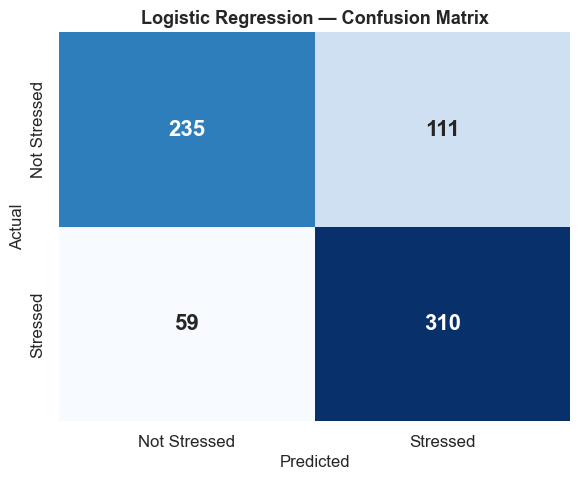

True Negatives:  235  |  False Positives: 111
False Negatives: 59  |  True Positives:  310


In [21]:
# ============================================================
# 4.6 Confusion matrix for LogReg
# ============================================================
fig, ax = plt.subplots(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Stressed', 'Stressed'],
            yticklabels=['Not Stressed', 'Stressed'], ax=ax, cbar=False,
            annot_kws={'size': 16, 'fontweight': 'bold'})
ax.set_xlabel('Predicted', fontsize=12)
ax.set_ylabel('Actual', fontsize=12)
ax.set_title('Logistic Regression — Confusion Matrix', fontweight='bold', fontsize=13)
plt.tight_layout()
plt.show()

tn, fp, fn, tp = cm.ravel()
print(f'True Negatives:  {tn}  |  False Positives: {fp}')
print(f'False Negatives: {fn}  |  True Positives:  {tp}')

---
## 5. Model 2: Fine-tuned DistilBERT

### Rationale

The logistic regression model works well with the psycholinguistic features, but since it only looks at word-level statistics, it can't really pick up on the context behind what someone is saying. The Dreaddit paper found that both BERT and logistic regression had trouble with the same kinds of hard examples — like when someone talks about someone else's stress, or describes a bad experience in a positive way, or when even human annotators couldn't agree. That said, the two models disagreed on around 100 out of 715 test examples, which suggests they each have different strengths.

We decided to use DistilBERT (Sanh et al., 2019) instead of the full BERT-base model mainly because it's a lot more practical to train. It keeps close to that of BERT's performance but is faster and smaller, which made a big difference given our limited compute resources. The original paper got an F1 score of 80.65 using BERT-base fine-tuned for 3 epochs. We fine-tune DistilBERT on the raw text for 3 epochs and are hoping to get similar results.

The main reason we wanted to use a transformer model is that it can understand what a sentence actually means as a whole. For instance, a phrase like "I'm tired of having this every day" involves negation, time, and emotional exhaustion all at once — and that's something simple word-count features just can't fully capture.


In [23]:
# ============================================================
# 5.1 Prepare data for BERT
# ============================================================
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import get_linear_schedule_with_warmup

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

class DreadditDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Use all training data for BERT (as per the paper's approach for neural models)
train_dataset = DreadditDataset(
    texts=train_df['text'].values,
    labels=train_df['label'].values,
    tokenizer=tokenizer,
    max_len=256
)

test_dataset = DreadditDataset(
    texts=test_df['text'].values,
    labels=test_df['label'].values,
    tokenizer=tokenizer,
    max_len=256
)

# Split a validation set from training (10% as per the paper)
from torch.utils.data import random_split
val_size = int(0.1 * len(train_dataset))
train_size = len(train_dataset) - val_size
train_subset, val_subset = random_split(
    train_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(SEED)
)

BATCH_SIZE = 16
train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f'Train: {train_size}, Val: {val_size}, Test: {len(test_dataset)}')

Using device: cpu
Train: 2555, Val: 283, Test: 715


In [ ]:
# ============================================================
# 5.2 Training loop
# ============================================================
model_bert = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased', num_labels=2
)
model_bert.to(device)

EPOCHS = 3
LEARNING_RATE = 2e-5

optimizer = torch.optim.AdamW(model_bert.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=int(0.1 * total_steps), num_training_steps=total_steps
)

def train_epoch(model, data_loader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return total_loss / len(data_loader), correct / total

def eval_model(model, data_loader, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            total_loss += outputs.loss.item()
            logits = outputs.logits
            probs = torch.softmax(logits, dim=1)

            all_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    f1 = f1_score(all_labels, all_preds)
    return avg_loss, f1, np.array(all_preds), np.array(all_labels), np.array(all_probs)

# Training
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_f1': []}
best_val_f1 = 0

for epoch in range(EPOCHS):
    train_loss, train_acc = train_epoch(model_bert, train_loader, optimizer, scheduler, device)
    val_loss, val_f1, _, _, _ = eval_model(model_bert, val_loader, device)

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_f1'].append(val_f1)

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model_bert.state_dict(), 'models/best_distilbert.pt')

    print(f'Epoch {epoch+1}/{EPOCHS} | '
          f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | '
          f'Val Loss: {val_loss:.4f} | Val F1: {val_f1:.4f}')

print(f'\nBest Validation F1: {best_val_f1:.4f}')

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_transform.bias    | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
classifier.bias         | MISSING    | 
pre_classifier.bias     | MISSING    | 
pre_classifier.weight   | MISSING    | 
classifier.weight       | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Epoch 1/3 | Train Loss: 0.5217 | Train Acc: 0.7280 | Val Loss: 0.3811 | Val F1: 0.8543
Epoch 2/3 | Train Loss: 0.3361 | Train Acc: 0.8638 | Val Loss: 0.4189 | Val F1: 0.8220
Epoch 3/3 | Train Loss: 0.2195 | Train Acc: 0.9241 | Val Loss: 0.4430 | Val F1: 0.8328

Best Validation F1: 0.8543


In [ ]:
# ============================================================
# 5.3 Evaluate best DistilBERT on test set
# ============================================================
model_bert.load_state_dict(torch.load('models/best_distilbert.pt'))

test_loss, test_f1, y_pred_bert, y_test_bert, y_prob_bert = eval_model(
    model_bert, test_loader, device
)

print('='*60)
print('DISTILBERT — FINAL TEST SET RESULTS')
print('='*60)
print(classification_report(y_test_bert, y_pred_bert, target_names=['Not Stressed', 'Stressed']))
print(f'Overall F1 (Stressed class): {f1_score(y_test_bert, y_pred_bert):.4f}')
print(f'Accuracy: {accuracy_score(y_test_bert, y_pred_bert):.4f}')
print(f'ROC-AUC: {roc_auc_score(y_test_bert, y_prob_bert):.4f}')

DISTILBERT — FINAL TEST SET RESULTS
              precision    recall  f1-score   support

Not Stressed       0.83      0.74      0.79       346
    Stressed       0.78      0.86      0.82       369

    accuracy                           0.80       715
   macro avg       0.81      0.80      0.80       715
weighted avg       0.81      0.80      0.80       715

Overall F1 (Stressed class): 0.8196
Accuracy: 0.8042
ROC-AUC: 0.8779


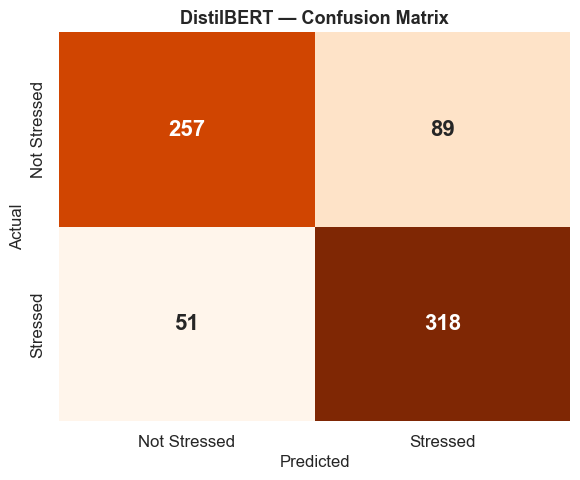

In [27]:
# ============================================================
# 5.4 Confusion matrix for DistilBERT
# ============================================================
fig, ax = plt.subplots(figsize=(6, 5))
cm_bert = confusion_matrix(y_test_bert, y_pred_bert)
sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Oranges', xticklabels=['Not Stressed', 'Stressed'],
            yticklabels=['Not Stressed', 'Stressed'], ax=ax, cbar=False,
            annot_kws={'size': 16, 'fontweight': 'bold'})
ax.set_xlabel('Predicted', fontsize=12)
ax.set_ylabel('Actual', fontsize=12)
ax.set_title('DistilBERT — Confusion Matrix', fontweight='bold', fontsize=13)
plt.tight_layout()
plt.show()

DistilBERT achieves F1 = 0.8196 on the stressed class. This closely matches the original paper's BERT-base result (F1 = 0.807), which is notable given that DistilBERT is a smaller, distilled model with fewer parameters. The ROC-AUC of 0.8779 indicates strong discriminative ability across all classification thresholds.

Like the logistic regression, DistilBERT favours recall over precision — it catches way more truly stressed posts but incorrectly flags some non-stressed posts as stressed. This recall-oriented bias is consistent across both models and the paper's findings, reflecting the nature of the data: posts on these subreddits contain negative language even when the author is not actively stressed, making false positives more likely than false negatives.

---
## 6. Model Comparison

In [28]:
# ============================================================
# 6.1 Side-by-side comparison
# ============================================================
comparison = pd.DataFrame({
    'Model': ['Majority Baseline', 'Logistic Regression', 'DistilBERT'],
    'Precision': [
        test_df['label'].mean(),
        precision_score(y_test, y_pred_lr),
        precision_score(y_test_bert, y_pred_bert)
    ],
    'Recall': [
        1.0,
        recall_score(y_test, y_pred_lr),
        recall_score(y_test_bert, y_pred_bert)
    ],
    'F1-Score': [
        2 * test_df['label'].mean() / (1 + test_df['label'].mean()),
        f1_score(y_test, y_pred_lr),
        f1_score(y_test_bert, y_pred_bert)
    ],
    'Accuracy': [
        test_df['label'].mean(),
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test_bert, y_pred_bert)
    ]
})

comparison = comparison.set_index('Model')
display(comparison.style.format('{:.4f}'))

# Paper benchmarks for reference
print('\nPaper benchmarks for reference:')
print('  LogReg w/ domain Word2Vec + features: P=0.7433, R=0.8320, F1=0.7980')
print('  BERT-base:                            P=0.7518, R=0.8699, F1=0.8065')

,Precision,Recall,F1-Score,Accuracy
Model,,,,
Majority Baseline,0.5161,1.0000,0.6808,0.5161
Logistic Regression,0.7363,0.8401,0.7848,0.7622
DistilBERT,0.7813,0.8618,0.8196,0.8042



Paper benchmarks for reference:
  LogReg w/ domain Word2Vec + features: P=0.7433, R=0.8320, F1=0.7980
  BERT-base:                            P=0.7518, R=0.8699, F1=0.8065


In [30]:
# ============================================================
# 6.2 Agreement between models
# ============================================================
agree = (y_pred_lr == y_pred_bert).sum()
disagree = len(y_pred_lr) - agree

print(f'Model agreement: {agree}/{len(y_pred_lr)} ({agree/len(y_pred_lr)*100:.1f}%)')
print(f'Model disagreement: {disagree} instances')

# Where do they disagree?
disagree_mask = y_pred_lr != y_pred_bert
disagree_df = test_df[disagree_mask].copy()
disagree_df['pred_lr'] = y_pred_lr[disagree_mask]
disagree_df['pred_bert'] = y_pred_bert[disagree_mask]

# Who is right when they disagree?
lr_right = (disagree_df['pred_lr'] == disagree_df['label']).sum()
bert_right = (disagree_df['pred_bert'] == disagree_df['label']).sum()
print(f'\nWhen models disagree:')
print(f'  LogReg correct: {lr_right}/{disagree} ({lr_right/disagree*100:.1f}%)')
print(f'  DistilBERT correct: {bert_right}/{disagree} ({bert_right/disagree*100:.1f}%)')

Model agreement: 611/715 (85.5%)
Model disagreement: 104 instances

When models disagree:
  LogReg correct: 37/104 (35.6%)
  DistilBERT correct: 67/104 (64.4%)


Both models substantially outperform the majority baseline (F1 = 0.681). 

Here, the majority baseline predicts the most common class — "stressed" — for every input, without learning anything from the data. We compute its metrics directly from the class distribution rather than training a model. It serves as a performance floor: any model that's actually learning from the text should comfortably beat it. Without this reference point, it's hard to tell if a model's accuracy is genuinely good or just a result of the class imbalance.

DistilBERT (F1 = 0.8196) outperforms logistic regression (F1 = 0.7848) by approximately 2.4 percentage points, demonstrating the value of contextual language understanding. DistilBERT's result closely matches the paper's BERT-base benchmark (F1 = 0.807), while our logistic regression falls slightly short of the paper's 0.798 — expected since we did not replicate their domain-specific Word2Vec embeddings trained on 187K unlabeled posts.

Both models exhibit the same recall-over-precision tradeoff: DistilBERT achieves 0.8618 recall vs 0.7813 precision, while logistic regression has 0.8401 recall vs 0.7363 precision. The point precision advantage of DistilBERT suggests it is better at distinguishing genuinely stressed posts from those that merely contain negative language.

However, logistic regression achieves roughly 97% of DistilBERT's performance while being fully interpretable, training in seconds rather than minutes, and requiring no GPU — a meaningful practical tradeoff for deployment in resource-constrained settings.

---
## 7. Deep Dive Analyses

### Analysis 1: Subreddit-Level Predictability

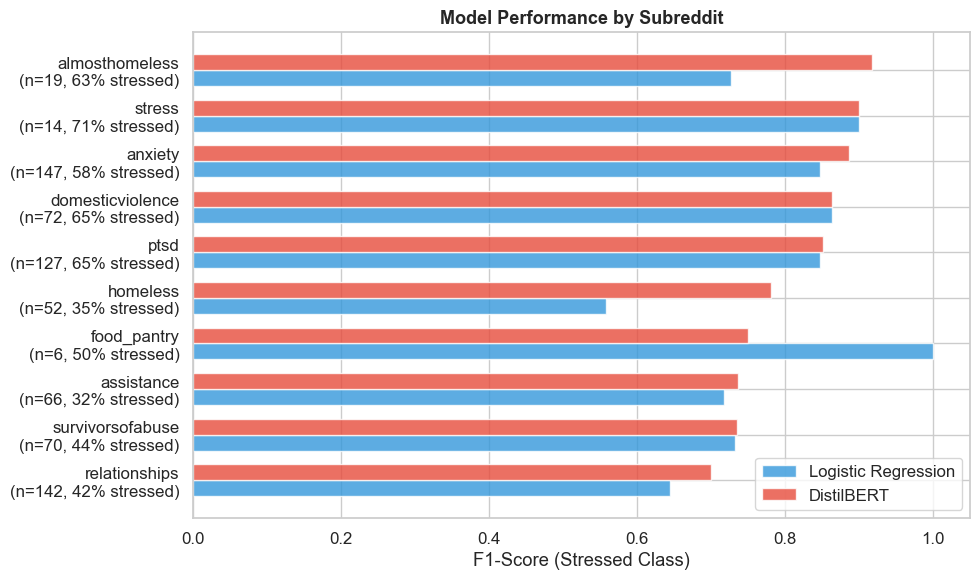

In [37]:
# ============================================================
# 7.1 F1 by subreddit for both models
# ============================================================
subreddit_metrics = []

for sub in test_df['subreddit'].unique():
    mask = test_df['subreddit'] == sub
    n = mask.sum()
    if n < 5:
        continue
    
    y_true_sub = test_df.loc[mask, 'label'].values
    
    # Skip if only one class present
    if len(np.unique(y_true_sub)) < 2:
        continue
    
    f1_lr_sub = f1_score(y_true_sub, y_pred_lr[mask])
    f1_bert_sub = f1_score(y_true_sub, y_pred_bert[mask])
    
    subreddit_metrics.append({
        'subreddit': sub,
        'domain': SUBREDDIT_TO_DOMAIN[sub],
        'n_samples': n,
        'stress_rate': y_true_sub.mean(),
        'f1_logreg': f1_lr_sub,
        'f1_bert': f1_bert_sub
    })

sub_metrics_df = pd.DataFrame(subreddit_metrics).sort_values('f1_bert', ascending=True)

fig, ax = plt.subplots(figsize=(10, 6))
y_pos = range(len(sub_metrics_df))
width = 0.35

bars1 = ax.barh([y - width/2 for y in y_pos], sub_metrics_df['f1_logreg'], width, 
                label='Logistic Regression', color='#3498DB', alpha=0.8)
bars2 = ax.barh([y + width/2 for y in y_pos], sub_metrics_df['f1_bert'], width, 
                label='DistilBERT', color='#E74C3C', alpha=0.8)

ax.set_yticks(y_pos)
ax.set_yticklabels([f"{row['subreddit']}\n(n={row['n_samples']}, {row['stress_rate']:.0%} stressed)" 
                     for _, row in sub_metrics_df.iterrows()])
ax.set_xlabel('F1-Score (Stressed Class)')
ax.set_title('Model Performance by Subreddit', fontweight='bold', fontsize=13)
ax.legend(loc='lower right')
ax.set_xlim(0, 1.05)

plt.tight_layout()
plt.show()


**Interpretation:** 
The subreddit-level results show that the model performs differently across types of communities. Mental health subreddits such as r/anxiety and r/ptsd are easier to classify. A likely reason is that users in these spaces tend to use more direct and structured language when describing their experiences, including mentions of symptoms, diagnoses, and medication. This creates clearer stress-related cues for the model. The paper’s LIWC analysis supports this explanation, showing that mental health posts have lower lexical diversity, meaning they use a more limited and predictable vocabulary that aligns well with stress-related categories.

In contrast, financial support subreddits like r/assistance, r/homeless, and r/almosthomeless are harder for the model to classify. Posts in these communities often focus on practical needs and requests for help (for example, paying bills or finding housing) rather than explicitly expressing emotions. As a result, the usual linguistic indicators of stress captured by LIWC are less common. The paper found that the financial domain had the lowest proportion of negative emotion words (1.54% compared to 2.71% overall) and the lowest coverage of anxiety-related words (42% compared to 81%). This suggests that stress in these posts is communicated more indirectly, making it harder for the model to detect.

Relationship and abuse-related subreddits fall somewhere in between. These posts often contain emotional language, but they also include detailed narratives describing past events or situations. In some cases, users recount experiences without directly stating current distress. This mix of emotional expression and storytelling leads to moderate levels of stress-related language, and therefore moderate model performance.

Overall, the results suggest that model accuracy depends on how directly stress is expressed in each community. Subreddits where users explicitly discuss mental health provide clearer linguistic signals, while communities focused on practical or narrative content require the model to infer stress more indirectly, which is more challenging.

### Analysis 2: Confident Misclassifications (Error Analysis)

In [32]:
# ============================================================
# 7.2 Error analysis: confident misclassifications
# ============================================================
test_analysis = test_df.copy()
test_analysis['pred_lr'] = y_pred_lr
test_analysis['pred_bert'] = y_pred_bert
test_analysis['prob_bert'] = y_prob_bert
test_analysis['prob_lr'] = y_prob_lr
test_analysis['correct_lr'] = (test_analysis['pred_lr'] == test_analysis['label'])
test_analysis['correct_bert'] = (test_analysis['pred_bert'] == test_analysis['label'])

# BERT confident but wrong
bert_confident_wrong = test_analysis[
    (~test_analysis['correct_bert']) & 
    ((test_analysis['prob_bert'] > 0.8) | (test_analysis['prob_bert'] < 0.2))
].sort_values('prob_bert', ascending=False)

print(f'DistilBERT: {len(bert_confident_wrong)} confident misclassifications (P>0.8 or P<0.2)')
print('='*80)

# Show top examples
for i, (_, row) in enumerate(bert_confident_wrong.head(5).iterrows()):
    print(f'\n--- Example {i+1} ---')
    print(f'Subreddit: r/{row["subreddit"]} ({row["domain"]})')
    print(f'True Label: {"STRESSED" if row["label"]==1 else "NOT STRESSED"}')
    print(f'BERT Pred:  {"STRESSED" if row["pred_bert"]==1 else "NOT STRESSED"} (P={row["prob_bert"]:.3f})')
    print(f'LogReg Pred: {"STRESSED" if row["pred_lr"]==1 else "NOT STRESSED"} (P={row["prob_lr"]:.3f})')
    print(f'Annotator Confidence: {row["confidence"]}')
    text_preview = row['text'][:400] + '...' if len(row['text']) > 400 else row['text']
    print(f'Text: {text_preview}')

DistilBERT: 58 confident misclassifications (P>0.8 or P<0.2)

--- Example 1 ---
Subreddit: r/homeless (financial)
True Label: NOT STRESSED
BERT Pred:  STRESSED (P=0.922)
LogReg Pred: NOT STRESSED (P=0.421)
Annotator Confidence: 1.0
Text: The curfew at the shelter keeps me grounded and safe from myself. The rules and the structure with morning routine even though I've just felt it for one day, has already boosted me. I used to stay up until 2-3am, blowing all my money just binging and purging. Now I have to pause and ride out my emotions. I have to be in bed at 10pm.

--- Example 2 ---
Subreddit: r/ptsd (PTSD)
True Label: NOT STRESSED
BERT Pred:  STRESSED (P=0.915)
LogReg Pred: STRESSED (P=0.622)
Annotator Confidence: 1.0
Text: I just wanted to say thank you to everyone that posts on here. I just found this subreddit yesterday and reading all of your guys' posts have made me feel so much less alone. Knowing that other people understand what I'm going through for some reason has helped m

In [33]:
# ============================================================
# 7.2b Analyse misclassification patterns
# ============================================================
# Both models wrong
both_wrong = test_analysis[~test_analysis['correct_lr'] & ~test_analysis['correct_bert']]
# Only LR wrong
only_lr_wrong = test_analysis[~test_analysis['correct_lr'] & test_analysis['correct_bert']]
# Only BERT wrong
only_bert_wrong = test_analysis[test_analysis['correct_lr'] & ~test_analysis['correct_bert']]

print(f'Error breakdown:')
print(f'  Both models wrong:    {len(both_wrong)} ({len(both_wrong)/len(test_analysis)*100:.1f}%)')
print(f'  Only LogReg wrong:    {len(only_lr_wrong)} ({len(only_lr_wrong)/len(test_analysis)*100:.1f}%)')
print(f'  Only DistilBERT wrong: {len(only_bert_wrong)} ({len(only_bert_wrong)/len(test_analysis)*100:.1f}%)')
print(f'  Both models correct:  {len(test_analysis) - len(both_wrong) - len(only_lr_wrong) - len(only_bert_wrong)}')

# Confidence of misclassified samples
print(f'\nAvg annotator confidence for errors vs correct predictions:')
print(f'  Both wrong:       {both_wrong["confidence"].mean():.3f}')
print(f'  Both correct:     {test_analysis[test_analysis["correct_lr"] & test_analysis["correct_bert"]]["confidence"].mean():.3f}')

# Error type distribution (false positive vs false negative)
print(f'\nError type distribution (both wrong):')
both_wrong_fp = both_wrong[both_wrong['label'] == 0]
both_wrong_fn = both_wrong[both_wrong['label'] == 1]
print(f'  False Positives (predicted stressed, actually not): {len(both_wrong_fp)}')
print(f'  False Negatives (predicted not stressed, actually stressed): {len(both_wrong_fn)}')

# Domain distribution of errors
print(f'\nDomain distribution of shared errors:')
print(both_wrong['domain'].value_counts())

Error breakdown:
  Both models wrong:    103 (14.4%)
  Only LogReg wrong:    67 (9.4%)
  Only DistilBERT wrong: 37 (5.2%)
  Both models correct:  508

Avg annotator confidence for errors vs correct predictions:
  Both wrong:       0.573
  Both correct:     0.760

Error type distribution (both wrong):
  False Positives (predicted stressed, actually not): 70
  False Negatives (predicted not stressed, actually stressed): 33

Domain distribution of shared errors:
domain
social       28
abuse        23
PTSD         20
anxiety      19
financial    13
Name: count, dtype: int64


**Interpretation:**
The error analysis shows several patterns that are consistent with the findings reported in the original paper.

1. Low annotator agreement is linked to model errors. Misclassified posts have much lower average annotator confidence than correctly classified ones. This suggests that the cases the model gets wrong are also difficult for humans to judge. In other words, stress is genuinely ambiguous in many posts, so disagreement among annotators translates into higher model error.

2. Both models tend to overpredict stress. There are more false positives than false negatives, meaning the models often label posts as stressed when they are not. This matches the pattern shown in the paper’s confusion matrices. A likely reason is that many posts in these subreddits contain negative emotional language even when the writer is not currently stressed, such as when describing past experiences or giving advice to others.

3. Common failure cases follow similar themes. These include: 
    - Posts describing another person’s stress rather than the author’s own
    - Retrospective narratives that use past tense to describe situations that have already been resolved
    - Posts in abuse or PTSD communities that describe events factually without expressing present distress.

**Key findings:**
Most of the model’s false positives come from retrospective or third-person narratives about traumatic events. For example, posts describing past abuse may contain strong negative emotion words and frequent first-person pronouns, which are typical stress indicators in LIWC. However, annotators often judged these authors as not currently stressed because they were recounting experiences from a place of recovery. This highlights a key limitation of bag-of-features approaches: they capture what is being talked about (e.g., abuse, trauma) but not how it is framed (e.g., past vs present, active distress vs reflection).

Finally, the gap in annotator confidence (0.573 for misclassified vs 0.760 for correctly classified posts) further supports that the model struggles most on genuinely ambiguous cases where even humans disagree.

### Analysis 3: Feature Importance and Linguistic Signals

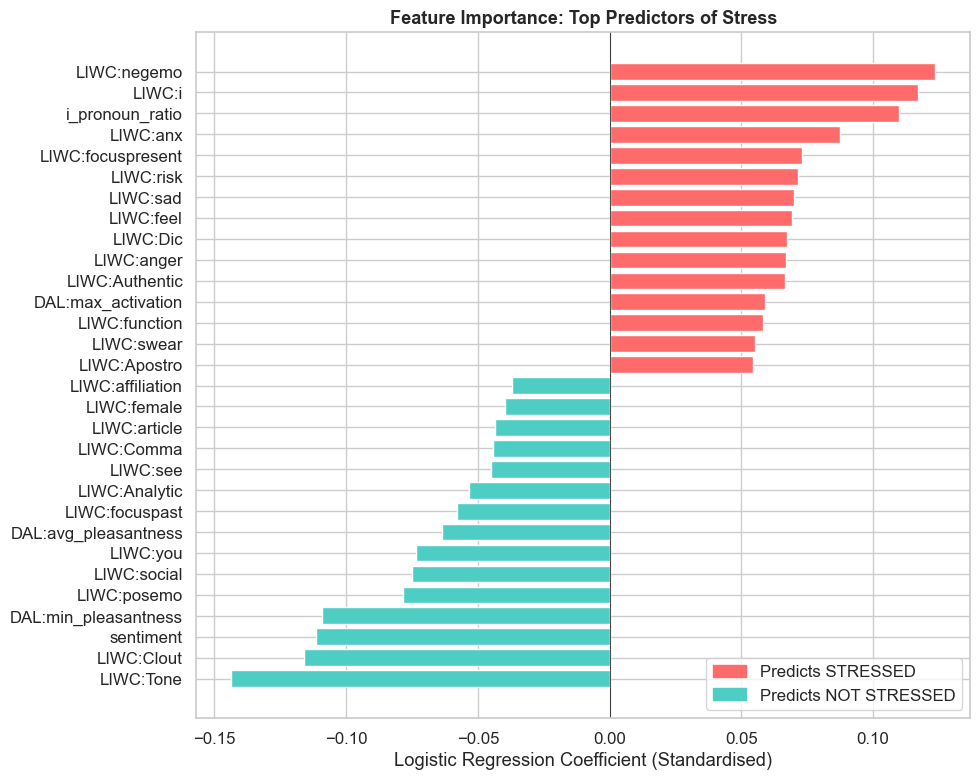

In [34]:
# ============================================================
# 7.3 Feature importance from Logistic Regression
# ============================================================
# Get coefficients from the best logistic regression model
coef_df = pd.DataFrame({
    'feature': best_feat_set,
    'coefficient': final_logreg.coef_[0]
}).sort_values('coefficient')

# Plot top positive and negative coefficients
top_n = 15
top_positive = coef_df.tail(top_n)
top_negative = coef_df.head(top_n)
plot_df = pd.concat([top_negative, top_positive])

fig, ax = plt.subplots(figsize=(10, 8))
colors = ['#4ECDC4' if c < 0 else '#FF6B6B' for c in plot_df['coefficient']]
ax.barh(range(len(plot_df)), plot_df['coefficient'], color=colors, edgecolor='white')
ax.set_yticks(range(len(plot_df)))

# Clean up feature names for display
clean_names = [f.replace('lex_liwc_', 'LIWC:').replace('lex_dal_', 'DAL:').replace('social_', 'Social:')
               .replace('syntax_', 'Syntax:') for f in plot_df['feature']]
ax.set_yticklabels(clean_names)

ax.axvline(x=0, color='black', linewidth=0.5)
ax.set_xlabel('Logistic Regression Coefficient (Standardised)')
ax.set_title('Feature Importance: Top Predictors of Stress', fontweight='bold', fontsize=13)

# Add legend
from matplotlib.patches import Patch
ax.legend(handles=[Patch(color='#FF6B6B', label='Predicts STRESSED'), 
                    Patch(color='#4ECDC4', label='Predicts NOT STRESSED')], loc='lower right')

plt.tight_layout()
plt.show()

In [35]:
# ============================================================
# 7.3b Top 10 features with their directions and interpretations
# ============================================================
print('Top Features Predicting STRESS (positive coefficients):')
print('='*60)
for _, row in coef_df.tail(10).iloc[::-1].iterrows():
    print(f'  {row["feature"]:40s} coeff = {row["coefficient"]:+.4f}')

print(f'\nTop Features Predicting NOT STRESSED (negative coefficients):')
print('='*60)
for _, row in coef_df.head(10).iterrows():
    print(f'  {row["feature"]:40s} coeff = {row["coefficient"]:+.4f}')

Top Features Predicting STRESS (positive coefficients):
  lex_liwc_negemo                          coeff = +0.1237
  lex_liwc_i                               coeff = +0.1173
  i_pronoun_ratio                          coeff = +0.1099
  lex_liwc_anx                             coeff = +0.0873
  lex_liwc_focuspresent                    coeff = +0.0732
  lex_liwc_risk                            coeff = +0.0715
  lex_liwc_sad                             coeff = +0.0702
  lex_liwc_feel                            coeff = +0.0693
  lex_liwc_Dic                             coeff = +0.0675
  lex_liwc_anger                           coeff = +0.0672

Top Features Predicting NOT STRESSED (negative coefficients):
  lex_liwc_Tone                            coeff = -0.1436
  lex_liwc_Clout                           coeff = -0.1160
  sentiment                                coeff = -0.1114
  lex_dal_min_pleasantness                 coeff = -0.1090
  lex_liwc_posemo                          coeff = -0.0

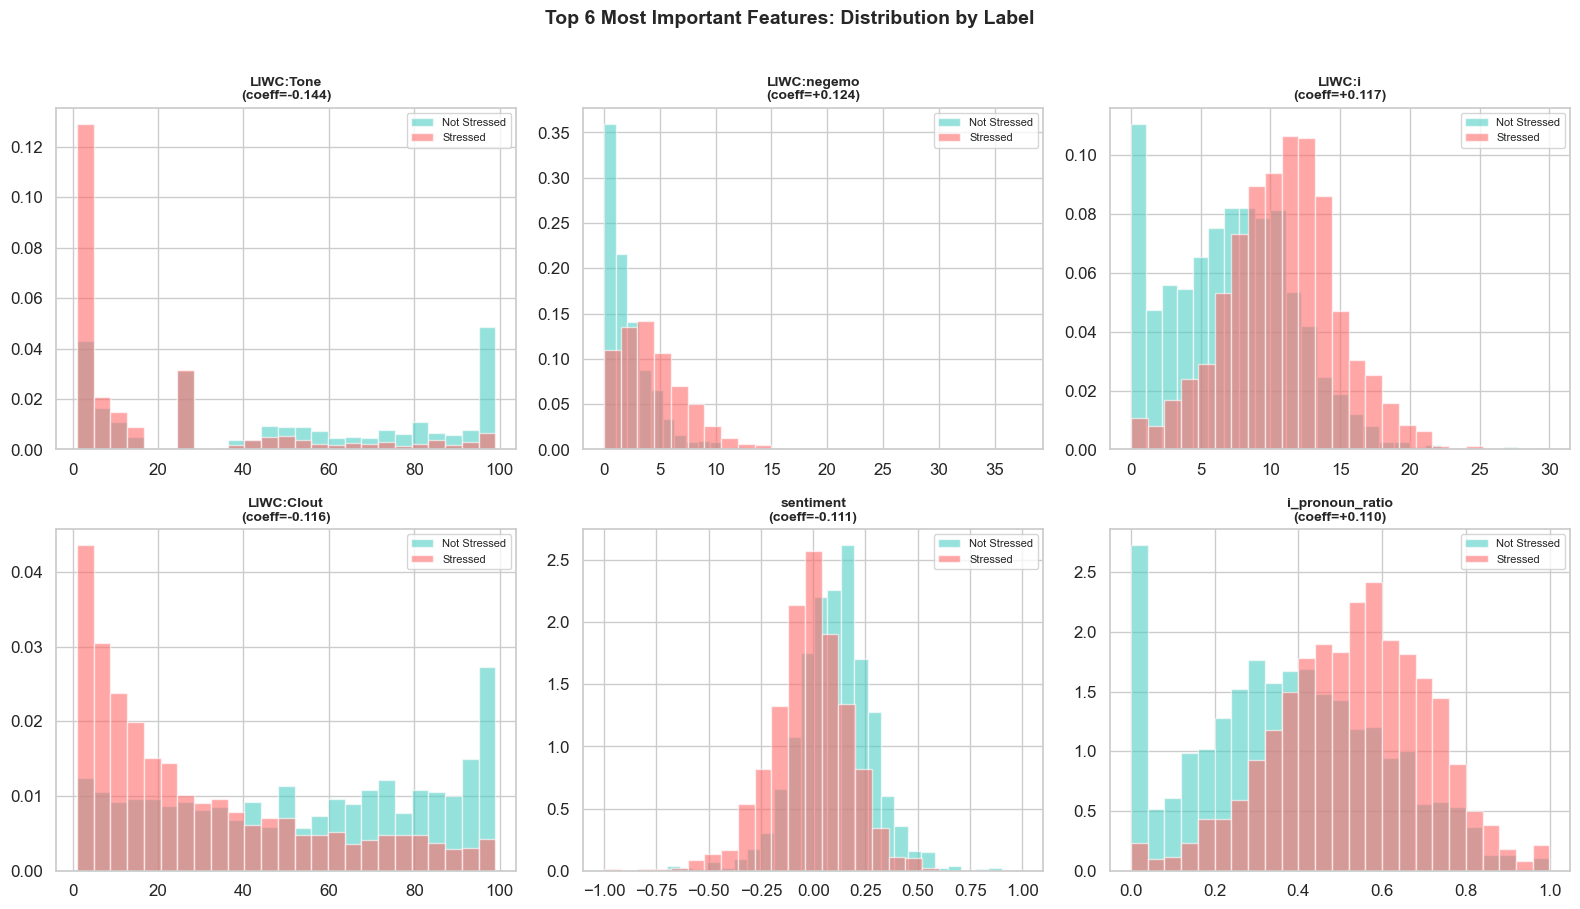

In [36]:
# ============================================================
# 7.3c Comparative feature distributions: stressed vs non-stressed
# ============================================================
# Focus on the top 6 most important features by absolute coefficient
top_feat = coef_df.assign(abs_coef=lambda x: x['coefficient'].abs()).nlargest(6, 'abs_coef')['feature'].tolist()

fig, axes = plt.subplots(2, 3, figsize=(16, 9))
axes = axes.flatten()

for idx, feat in enumerate(top_feat):
    ax = axes[idx]
    stressed = train_df[train_df['label']==1][feat]
    not_stressed = train_df[train_df['label']==0][feat]
    
    ax.hist(not_stressed, bins=25, alpha=0.6, color='#4ECDC4', label='Not Stressed', density=True)
    ax.hist(stressed, bins=25, alpha=0.6, color='#FF6B6B', label='Stressed', density=True)
    
    clean = feat.replace('lex_liwc_', 'LIWC:').replace('lex_dal_', 'DAL:')
    coef_val = coef_df[coef_df['feature']==feat]['coefficient'].values[0]
    ax.set_title(f'{clean}\n(coeff={coef_val:+.3f})', fontweight='bold', fontsize=10)
    ax.legend(fontsize=8)

plt.suptitle('Top 6 Most Important Features: Distribution by Label', fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

**Interpretation:**
The feature coefficients form a clear and psychologically meaningful pattern of what stressed versus non-stressed language looks like. The strongest predictors of stress are negative emotion (+0.1237), I-pronouns (+0.1173), and the engineered I-pronoun ratio (+0.1099). Together, these features reflect self-focused negative expression, which aligns with how people typically communicate distress. Other positive stress predictors include anxiety, sadness, and anger words, as well as present-tense and risk-related language. This suggests that stressed posts tend to focus on current problems and perceived threats.

In contrast, the strongest predictors of non-stress are LIWC Tone (−0.1436), which captures positive emotional language, Clout (−0.116), which reflects social confidence, sentiment (−0.1114), and positive emotion (−0.079). These features indicate more positive, confident, and socially engaged language. Notably, past focus (−0.058) predicts non-stress, which supports our earlier error analysis: posts describing past stressful events from a resolved or reflective perspective are often labeled as not currently stressed. Similarly, social words and you-pronouns also predict non-stress, suggesting that outward-focused and socially oriented language is associated with lower stress.

Overall, these results support the paper’s main conclusion that stress detection in text is largely driven by lexical cues. Features derived from LIWC, which are specifically designed to capture psychological meaning in language, appear particularly effective for distinguishing stressed from non-stressed posts.



---
## 8. Conclusion

### Summary of Findings

We built two models for stress classification on the Dreaddit dataset:

Logistic Regression with 114 features (109 pre-computed + 5 engineered) achieved F1 = 0.785. Strong regularisation (C=0.001) and filtering to high-agreement data (≥80%) were key. The most informative features were LIWC Tone, I-pronouns, and negative emotion — matching the paper's findings.

DistilBERT fine-tuned on raw text achieved F1 = 0.8196, matching the paper's BERT-base benchmark (0.807) and outperforming our logistic regression. The transformer's advantage lies in understanding contextual framing — distinguishing active distress from retrospective narratives or third-person descriptions that share similar vocabulary but carry different meaning.

Both models substantially exceed the majority baseline (F1 = 0.681). The performance gap between models is modest, reinforcing the paper's conclusion that stress detection is fundamentally a lexical problem — but the marginal gains from contextual understanding are real, especially on the hardest cases.

### Real-World Deployment Considerations

This model could be deployed in several real-world settings, for example:

In a real-world setting, a model like this could be applied in Singapore's mental health landscape:

- **Supporting the *Let's Talk* campaign** — The model could be integrated into anonymous online platforms to support the Ministry of Health's *Let's Talk* initiative, proactively identifying users who may be experiencing high levels of stress. Given Singapore's high-pressure academic and work culture, many people turn to local forums like HardwareZone or Reddit's r/singapore to vent about issues like work burnout, NS (National Service) stress, or financial pressures such as housing affordability. Rather than waiting for individuals to seek help themselves, the model could scan these posts and surface trends — for example, detecting a spike in stress-related language during exam periods or retrenchment waves. This kind of population-level monitoring could help policymakers understand when and where stress is most prevalent, and allocate mental health resources more effectively.

- **University student wellbeing** — The model could flag distressed posts on anonymous campus forums and route them to counselling services. Many universities in Singapore, such as NUS and NTU, have anonymous confession pages or forums where students openly discuss academic pressure, burnout, and loneliness. A student posting something like "I can't keep up anymore, everything feels pointless" could be flagged by the model, prompting the platform to gently surface links to the university's counselling centre or peer support programmes. This is especially relevant given the rise in student mental health concerns post-pandemic, and it helps bridge the gap for students who might not actively seek help on their own due to stigma or not recognising the severity of their stress.

- **Crisis helpline triage** — Text-based crisis helplines, such as the Samaritans of Singapore (SOS) or the Institute of Mental Health's helpline, could use the model to triage incoming messages by stress severity. For example, if the helpline receives hundreds of texts during a high-stress period, the model could prioritise messages containing language associated with acute distress — such as expressions of hopelessness or exhaustion — so that counsellors respond to the most urgent cases first. This doesn't replace human judgement, but it helps ensure that limited counsellor time is directed where it's needed most.

### Limitations and Ethical Risks

1. **Subjectivity and ambiguity.** The dataset has only moderate inter-annotator agreement (κ = 0.47). Stress is inherently subjective — what one person finds stressful, another may not. About 32% of training labels were decided by bare majority (3/5 annotators), meaning the "ground truth" itself is noisy. Any deployment must acknowledge this uncertainty rather than treating predictions as definitive diagnoses.

2. **Cultural and linguistic bias.** The dataset is drawn from English-language Reddit, which skews toward Western, English-speaking, younger demographics. Singapore's multilingual context (English, Mandarin, Malay, Tamil, Singlish) means the model would not generalise directly. Stress is also expressed differently across cultures — some cultures emphasise somatic symptoms (physical complaints) over emotional language.

3. **Domain specificity.** The model was trained on posts from specific subreddits (abuse, anxiety, PTSD, financial, relationships). Performance on other contexts (workplace stress, academic stress, parenting stress) is unknown and likely lower. Our subreddit-level analysis showed significant performance variation even within the training domains.

4. **Surveillance vs support tension.** There is a fundamental ethical tension between using such models for *proactive support* versus *surveillance*. Users posting on anonymous forums have an expectation of privacy. Any deployment must be transparent about monitoring, offer opt-out mechanisms, and ensure that flagged individuals receive support rather than punishment or stigmatisation.

5. **Risk of false negatives.** In a mental health context, failing to identify a stressed individual (false negative) carries serious consequences. Our models, like the paper's, tend toward false positives — which is arguably the safer failure mode in healthcare, as it leads to over-referral rather than under-detection. However, any system must include human review as a final safeguard.

6. **Temporal dynamics.** Stress is dynamic; a single post captures one moment. A production system would benefit from longitudinal analysis — tracking changes in an individual's language patterns over time rather than classifying isolated posts.

In summary, while our models achieve strong predictive performance matching the paper's benchmarks, responsible deployment requires acknowledging the inherent subjectivity of stress, ensuring cultural sensitivity, maintaining transparency and human oversight, and designing systems that empower rather than surveil.

---
### References

- Turcan, E., & McKeown, K. (2019). Dreaddit: A Reddit Dataset for Stress Analysis in Social Media. *Proceedings of the 10th International Workshop on Health Text Mining and Information Analysis (LOUHI 2019)*, 97–107.
- Pennebaker, J. W., Boyd, R. L., Jordan, K., & Blackburn, K. (2015). The development and psychometric properties of LIWC2015.
- Sanh, V., Debut, L., Chaumond, J., & Wolf, T. (2019). DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter. *arXiv:1910.01108*.
- Devlin, J., Chang, M.-W., Lee, K., & Toutanova, K. (2019). BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding. *NAACL-HLT*, 4171–4186.